In [29]:
import cv2 
import matplotlib.pyplot as plt


In [30]:
# Input image 
image = cv2.imread('image.jpg') 
image = cv2.resize(image, (720, 640))


In [31]:
# Importing Models and set mean values 
face1 = "opencv_face_detector.pbtxt"
face2 = "opencv_face_detector_uint8.pb"
age1 = "age_deploy.prototxt"
age2 = "age_net.caffemodel"
gen1 = "gender_deploy.prototxt"
gen2 = "gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746) 

# Using models 
# Face 
face = cv2.dnn.readNet(face2, face1) 

# age 
age = cv2.dnn.readNet(age2, age1) 

# gender 
gen = cv2.dnn.readNet(gen2, gen1) 


In [32]:
# Categories of distribution 
la = ['(0-2)', '(4-6)', '(8-12)', '(15-20)','(21-24)' ,
	'(25-32)', '(38-43)', '(48-53)', '(60-100)'] 
lg = ['Male', 'Female'] 


In [33]:
# Copy image 
fr_cv = image.copy()


In [34]:
# Face detection 
fr_h = fr_cv.shape[0] 
fr_w = fr_cv.shape[1] 
blob = cv2.dnn.blobFromImage(fr_cv, 1.0, (300, 300), 
							[104, 117, 123], True, False) 

face.setInput(blob) 
detections = face.forward()


In [35]:
# Face bounding box creation 
faceBoxes = [] 
for i in range(detections.shape[2]): 
	
	#Bounding box creation if confidence > 0.7 
	confidence = detections[0, 0, i, 2] 
	if confidence > 0.7: 
		
		x1 = int(detections[0, 0, i, 3]*fr_w) 
		y1 = int(detections[0, 0, i, 4]*fr_h) 
		x2 = int(detections[0, 0, i, 5]*fr_w) 
		y2 = int(detections[0, 0, i, 6]*fr_h) 
		
		faceBoxes.append([x1, y1, x2, y2]) 
		
		cv2.rectangle(fr_cv, (x1, y1), (x2, y2), 
					(0, 255, 0), int(round(fr_h/150)), 8) 
		
faceBoxes


[]

In [36]:
# Checking if face detected or not 
if not faceBoxes: 
	print("No face detected") 

# Final results (otherwise) 
# Loop for all the faces detected 
for faceBox in faceBoxes: 
	
	#Extracting face as per the faceBox 
	face = fr_cv[max(0, faceBox[1]-15): 
				min(faceBox[3]+15, fr_cv.shape[0]-1), 
				max(0, faceBox[0]-15):min(faceBox[2]+15, 
							fr_cv.shape[1]-1)] 
	
	#Extracting the main blob part 
	blob = cv2.dnn.blobFromImage( 
		face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False) 
	
	#Prediction of gender 
	gen.setInput(blob) 
	genderPreds = gen.forward() 
	gender = lg[genderPreds[0].argmax()] 
	
	#Prediction of age 
	age.setInput(blob) 
	agePreds = age.forward() 
	age = la[agePreds[0].argmax()] 
	print(age,gender)
	#Putting text of age and gender 
	#At the top of box 
	cv2.putText(fr_cv, 
				f'{gender}, {age}', 
				(faceBox[0]-150, faceBox[1]+10), 
				cv2.FONT_HERSHEY_SIMPLEX, 
				1.3, 
				(217, 0, 0), 
				4, 
				cv2.LINE_AA) 

	plt.figure(figsize=(7, 7)) 
	plt.imshow(fr_cv)


No face detected


In [1]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

import os
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split

In [2]:
dataset_folder='train/'
sub_folders=os.listdir(dataset_folder)

sub_folders

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

In [3]:
# Reading folder names as labels and images underneath
i=0
last=[]
images=[]
labels=[]
temp = sub_folders

# reading folders in the main dataset folder, one at a time
for sub_folder in sub_folders:
  sub_folder_index = temp.index(sub_folder)
  label = sub_folder_index

  # Define labels basis use case. We are using positive:0, negative:1, neutral:2 
  # for our use case of predicting emotions of visitors entering a retail store
  if  label in [4, 6]:    # label in ['happy', 'surprise']
    new_label=0           # changed to label = positive emotion
  elif label in [0,5]:      # label in ['anger','sadness']
    new_label=1           # changed to label = negative emotion
  else:                   # label in ['contempt', 'disgust', 'fear']
    new_label=2           # changed to label = neutral emotion
  
  
  path = dataset_folder+'/'+sub_folder
  sub_folder_images= os.listdir(path)
  
  # reading images in the sub folder, one at a time
  for image in sub_folder_images:
    image_path = path+'/'+image
    print(image_path+"\t"+str(new_label))
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image= cv2.resize(image,(48,48))
    images.append(image)
    labels.append(new_label)
    i+=1
  last.append(i)

train//anger/S010_004_00000017.png	1
train//anger/S010_004_00000018.png	1
train//anger/S010_004_00000019.png	1
train//anger/S011_004_00000019.png	1
train//anger/S011_004_00000020.png	1
train//anger/S011_004_00000021.png	1
train//anger/S014_003_00000028.png	1
train//anger/S014_003_00000029.png	1
train//anger/S014_003_00000030.png	1
train//anger/S022_005_00000030.png	1
train//anger/S022_005_00000031.png	1
train//anger/S022_005_00000032.png	1
train//anger/S026_003_00000013.png	1
train//anger/S026_003_00000014.png	1
train//anger/S026_003_00000015.png	1
train//anger/S028_001_00000022.png	1
train//anger/S028_001_00000023.png	1
train//anger/S028_001_00000024.png	1
train//anger/S029_001_00000017.png	1
train//anger/S029_001_00000018.png	1
train//anger/S029_001_00000019.png	1
train//anger/S032_003_00000015.png	1
train//anger/S032_003_00000016.png	1
train//anger/S032_003_00000017.png	1
train//anger/S034_003_00000025.png	1
train//anger/S034_003_00000026.png	1
train//anger/S034_003_00000027.png	1
t

In [4]:
images_x = np.array(images)
labels_y = np.array(labels)

# we divide image pixels by 255 to reduce computation power
images_x = images_x/255

In [5]:
images_x.shape

(981, 48, 48)

In [6]:

# encoding the labels
num_of_classes = 3
labels_y_encoded = tf.keras.utils.to_categorical(labels_y,num_classes=num_of_classes)

In [7]:

X_train, X_test, Y_train, Y_test= train_test_split(images_x, labels_y_encoded,test_size=0.25, random_state=10)

In [8]:

len(X_train)

735

In [9]:

len(X_test)

246

In [10]:
len(Y_test)

246

In [11]:
len(Y_train)

735

In [12]:
input = Input(shape = (48,48,1))

conv1 = Conv2D(32,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2)) (conv1)

conv2 = Conv2D(64,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2)) (conv2)

conv3 = Conv2D(128,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2)) (conv3)

conv4 = Conv2D(256,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2)) (conv4)

flatten = Flatten()(pool4)

dense_1 = Dense(128,activation='relu')(flatten)

drop_1 = Dropout(0.2)(dense_1)

output = Dense(3,activation="sigmoid")(drop_1)

In [13]:
model = Model(inputs=input,outputs=output)
model.compile(optimizer="adam", loss=["categorical_crossentropy"], metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,267 (2.61 MB)

 Trainable params: 683,267 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:

model.save('./output/emotion_model.keras')

print("Model saved successfully.")


Model saved successfully.


In [17]:
fle_s='./output/emotion_model.keras'
checkpointer = ModelCheckpoint(fle_s, monitor='loss',verbose=1,save_best_only=True,
                               save_weights_only=False, mode='auto',save_freq='epoch')
callback_list=[checkpointer]

In [18]:

save = model.fit(X_train,Y_train,batch_size=32,validation_data=(X_test,Y_test),epochs=50,callbacks=[callback_list])

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4373 - loss: 1.3322
Epoch 1: loss improved from inf to 1.29079, saving model to ./output/emotion_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.4380 - loss: 1.3305 - val_accuracy: 0.5976 - val_loss: 1.2531
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4445 - loss: 1.2272
Epoch 2: loss improved from 1.29079 to 1.19909, saving model to ./output/emotion_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4448 - loss: 1.2260 - val_accuracy: 0.4756 - val_loss: 1.1518
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4780 - loss: 1.1416
Epoch 3: loss improved from 1.19909 to 1.12847, saving model to ./output/emotion_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.4775 - loss: 1.1411 - val_accuracy: 0.4959 - val_loss: 1.0799
Epoch 4/50
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4856 - loss: 1.0103
Epoch 4: loss improved from 1.12847 t

In [21]:

train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']
model.save('./output/emotion_model.keras')

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

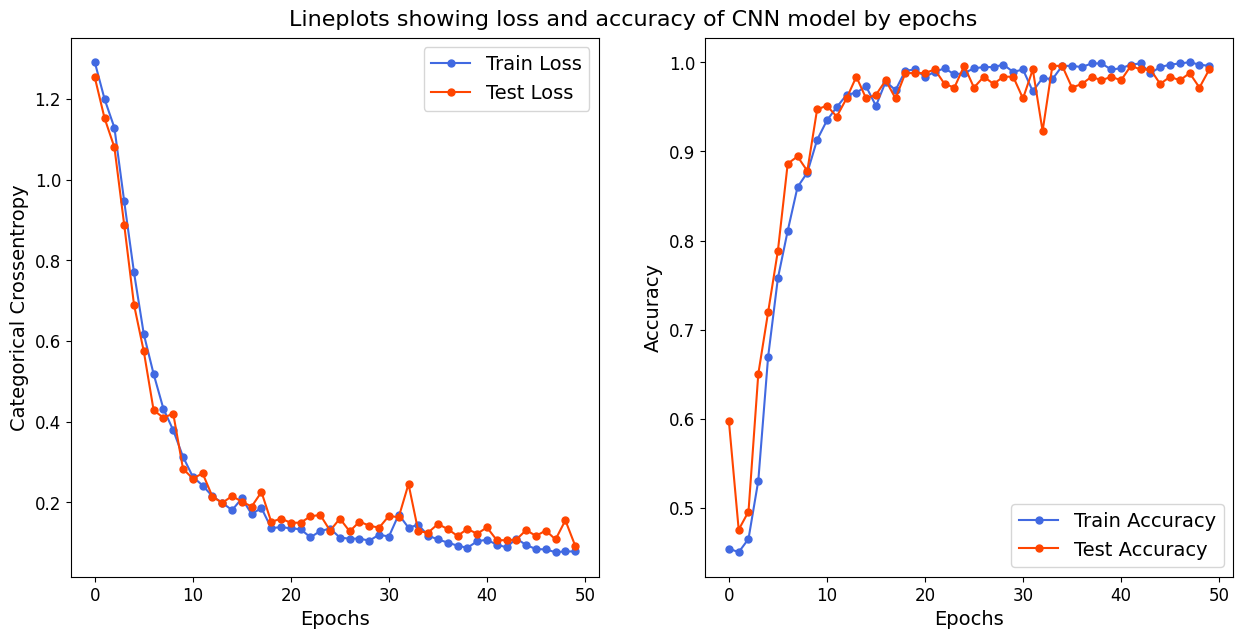

In [22]:

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

In [14]:
from keras.models import load_model
from PIL import Image
import numpy as np
import cv2

#the following are to do with this interactive notebook code

%matplotlib inline 
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook


In [15]:
export_dir='output/emotion_model.keras'
age_model = load_model(export_dir)

# summarize model.
age_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049,803 (7.82 MB)

 Trainable params: 683,267 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,366,536 (5.21 MB)

In [16]:
emotion_ranges= ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

In [17]:
img_path = "image.jpg"

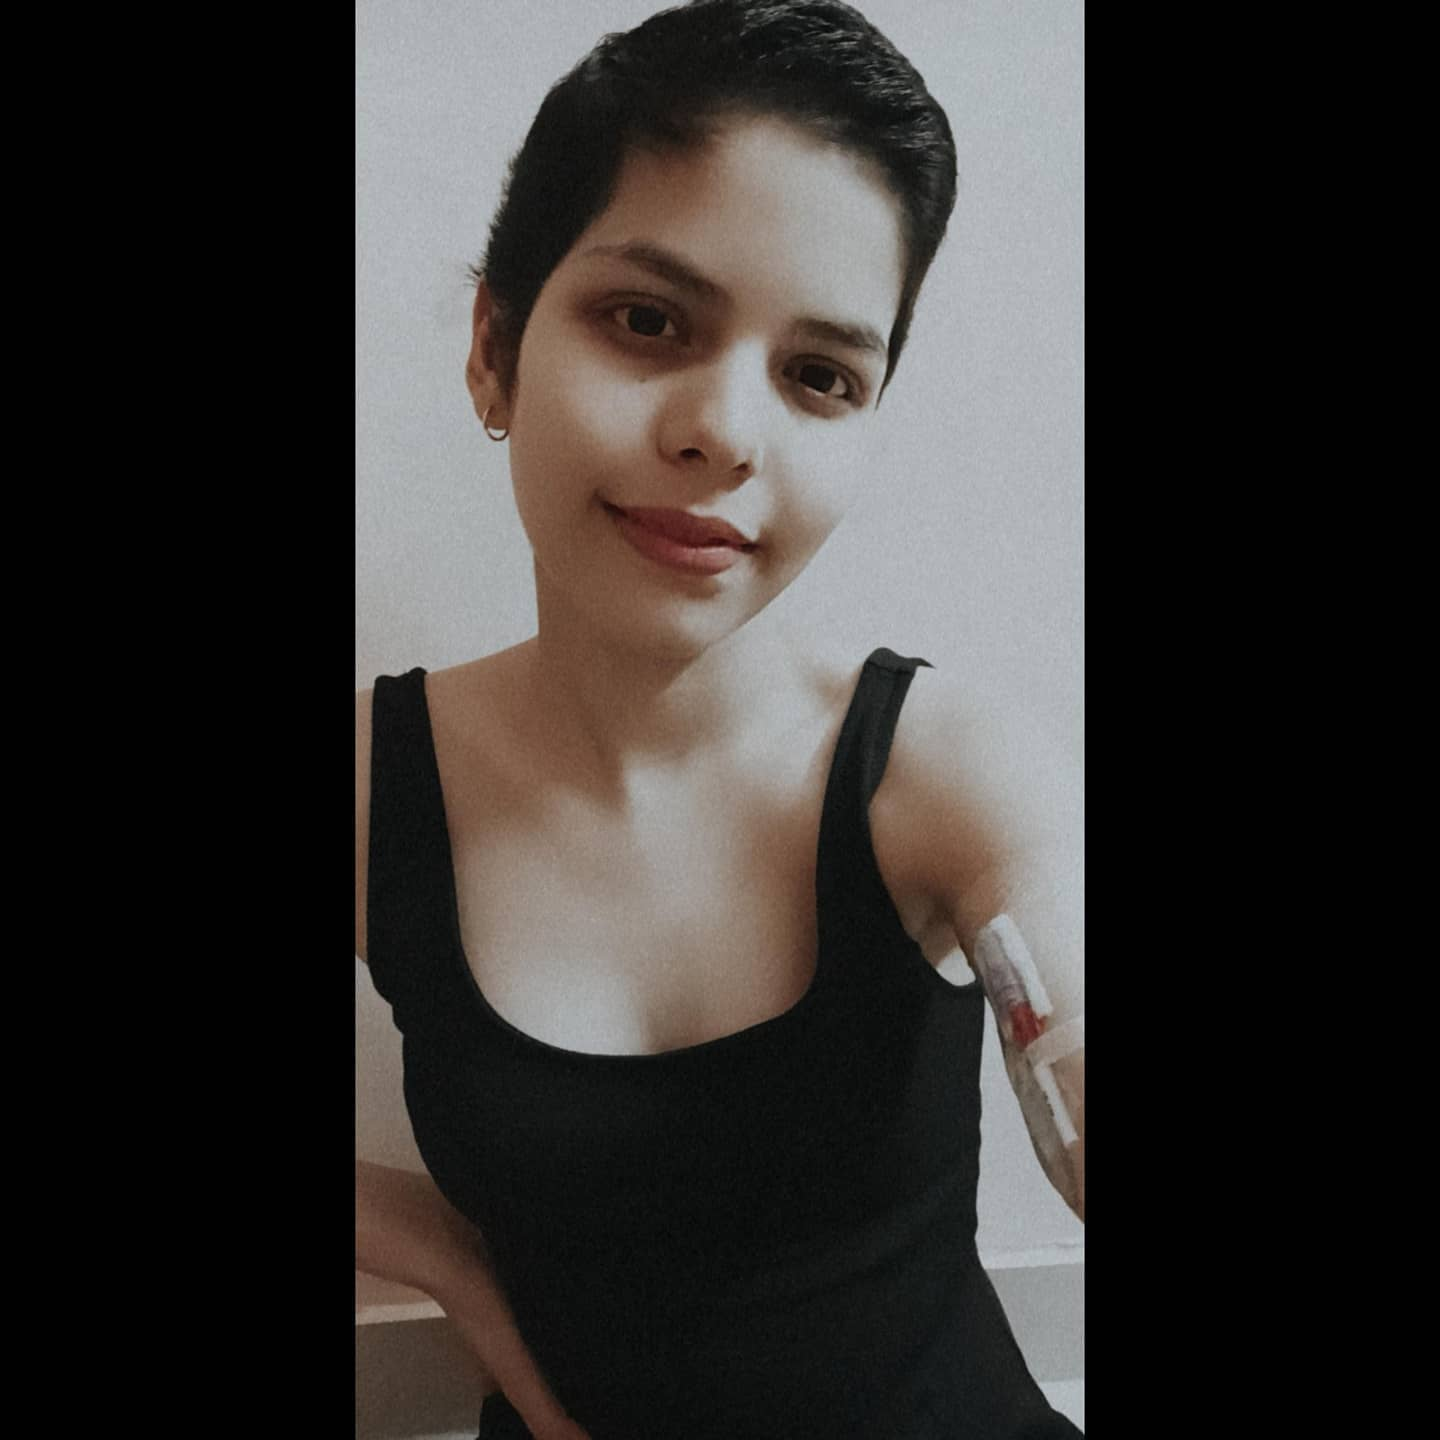

In [18]:

from IPython.display import Image 
pil_img = Image(filename=img_path)
display(pil_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1: disgust


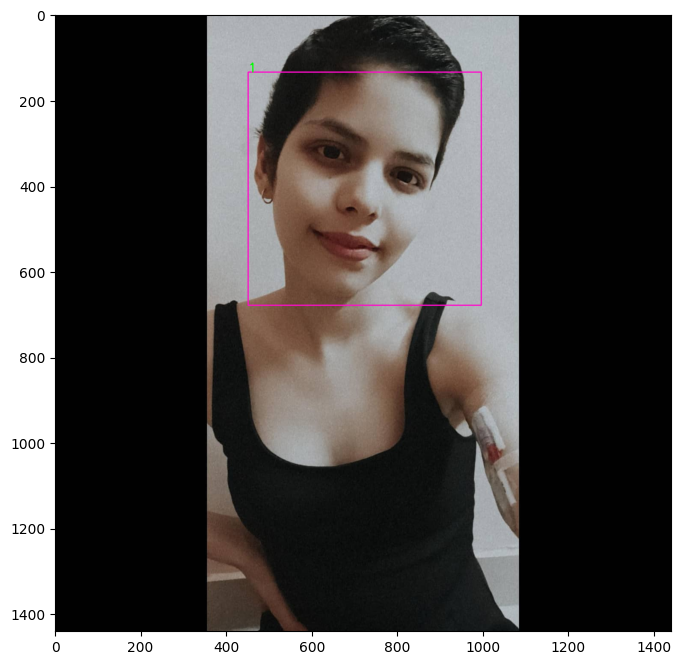

In [19]:
test_image = cv2.imread(img_path)
gray = cv2.cvtColor(test_image,cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier('./output/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

i = 0

for (x,y,w,h) in faces:
  i = i+1
  cv2.rectangle(test_image,(x,y),(x+w,y+h),(203,12,255),2)

  img_gray=gray[y:y+h,x:x+w]

  emotion_img = cv2.resize(img_gray, (48, 48), interpolation = cv2.INTER_AREA)
  emotion_image_array = np.array(emotion_img)
  emotion_input = np.expand_dims(emotion_image_array, axis=0)
  output_emotion= emotion_ranges[np.argmax(age_model.predict(emotion_input))]
  
  output_str = str(i) + ": "+ output_emotion
  print(output_str)
  
  col = (0,255,0)

  cv2.putText(test_image, str(i),(x,y),cv2.FONT_HERSHEY_SIMPLEX,1,col,2)

plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))